# A/B Testing

Is when different elements of a user's experience are tested to determine which variation helps the business achieve its goal more effectively (i.e. increasing conversions, etc). 



An A/B test is a randomized, controlled experiment in which the performance of two product variants are compared. Those variants are usually called A and B 1. From a business perspective we want to know if the performance of a certain variant outperforms the other.





The basic difference between the frequentist approach and the Bayesian is in the form in which the metric under study is form: for frequentists, it's a number, for bayesians it's a distribution.

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#A/B-Testing" data-toc-modified-id="A/B-Testing-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>A/B Testing</a></span><ul class="toc-item"><li><span><a href="#Generating-data" data-toc-modified-id="Generating-data-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Generating data</a></span></li></ul></li><li><span><a href="#Udacity---Google-course" data-toc-modified-id="Udacity---Google-course-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Udacity - Google course</a></span><ul class="toc-item"><li><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#other-tests......." data-toc-modified-id="other-tests.......-2.0.0.1"><span class="toc-item-num">2.0.0.1&nbsp;&nbsp;</span>other tests.......</a></span></li></ul></li></ul></li><li><span><a href="#Frequentist-A/B-testing" data-toc-modified-id="Frequentist-A/B-testing-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Frequentist A/B testing</a></span></li><li><span><a href="#Bayesian-approach-to-A/B-testing" data-toc-modified-id="Bayesian-approach-to-A/B-testing-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Bayesian approach to A/B testing</a></span></li></ul></li></ul></div>

## Generating data

In [1]:
# Loading the needed libraries
from scipy.stats import bernoulli, binom, beta
import numpy as np
from AB_Tester import ABTester
# Plot libraries and settings
import matplotlib.pyplot as plt
import seaborn as sns
from Plots import count_plot  # custom made plots
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
sns.set_style('dark')
# Re-load modules 
%load_ext autoreload
%autoreload 2

In [2]:
A = dict(impressions=16500, conversions=30)   # A := control group
B = dict(impressions=17000, conversions=50)   # B := test group

Create the Beta functions for the two sets

In [3]:
# True values (unknown for the A/B Test)
A_true_cr = 0.1
B_true_cr = 0.12
A_size = 2500
B_size = 1500

# Generate data: sample N Bernoulli random variates, each random variate has 0.05 chance of being 1
A_occurrences = bernoulli.rvs(A_true_cr, size=A_size)  
B_occurrences = bernoulli.rvs(B_true_cr, size=B_size)  

print(A_occurrences[:20]) 
print(np.sum(A_occurrences))

[0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0]
279


Observed frequency in Group A? 0.1116 
Observed frequency in Group B? 0.1160 
Does this equal the true frequency? False


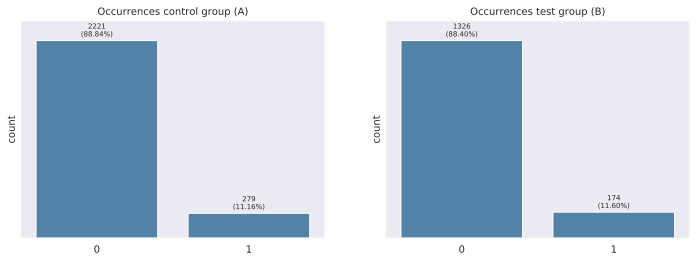

In [4]:
# Occurrences.mean is equal to n/N.
print("Observed frequency in Group A: {np.mean(A_occurrences)%.2%}")
print("Observed frequency in Group B: {np.mean(B_occurrences)%.2%}")
print("Does this equal the true frequency? %s" % (np.mean(A_occurrences) == A_true_cr))

plot, axes = plt.subplots(1, 2, figsize=(12, 4))
count_plot(A_occurrences, title='Occurrences control group (A)', ax=axes[0], show=False)
count_plot(B_occurrences, title='Occurrences test group (B)', ax=axes[1], show=False)
plt.show()

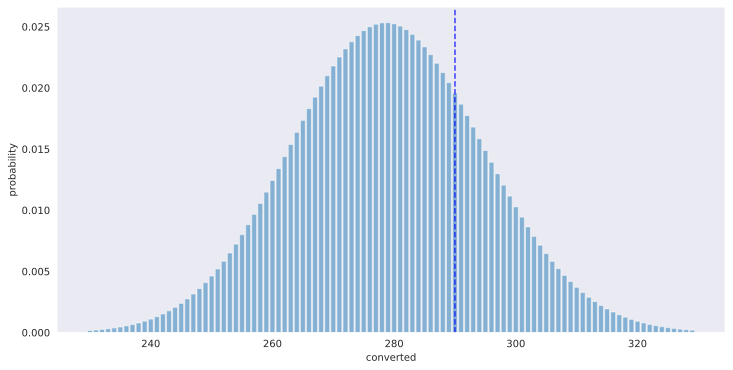

In [6]:
# .................
A_total = len(A_occurrences)
A_cr = sum(A_occurrences) / A_total
B_cr = sum(B_occurrences) / len(B_occurrences)
A_converted = A_total * A_cr
# .................
fig, ax = plt.subplots(figsize=(12,6))
x = np.linspace(A_converted-49, A_converted+50, 100)
y = binom(A_total, A_cr).pmf(x)
ax.bar(x, y, alpha=0.5)
ax.axvline(x=B_cr * A_total, c='blue', alpha=0.75, linestyle='--')
plt.xlabel('converted')
plt.ylabel('probability')
plt.show()

Text(0, 0.5, 'probability')

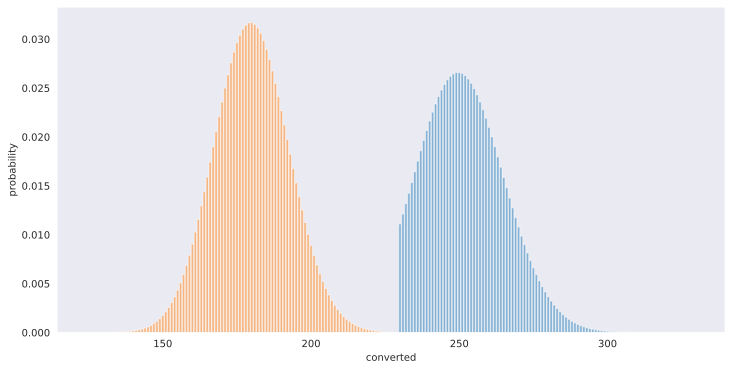

In [13]:
# .................
A_total = len(A_occurrences)
A_cr = sum(A_occurrences) / A_total

B_total = len(B_occurrences)
B_cr = sum(B_occurrences) / len(B_occurrences)
B_converted = B_total * B_cr
# .................
fig, ax = plt.subplots(figsize=(12,6))
xA = np.linspace(A_converted-49, A_converted+50, 100)
yA = binom(A_total, A_true_cr).pmf(xA)
ax.bar(xA, yA, alpha=0.5)
xB = np.linspace(B_converted-49, B_converted+50, 100)
yB = binom(B_total, B_true_cr).pmf(xB)
ax.bar(xB, yB, alpha=0.5)
plt.xlabel('converted')
plt.ylabel('probability')

NameError: name 'p_value' is not defined

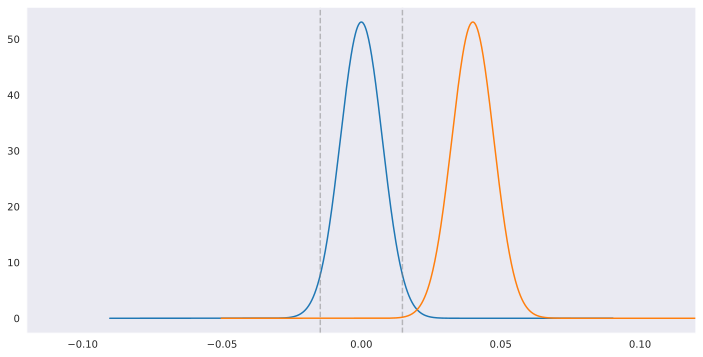

In [30]:
import scipy.stats as scs

def pooled_prob(N_A, N_B, X_A, X_B):
    """Returns pooled probability for two samples"""
    return (X_A + X_B) / (N_A + N_B)

def pooled_SE(N_A, N_B, X_A, X_B):
    """Returns the pooled standard error for two samples"""
    p_hat = pooled_prob(N_A, N_B, X_A, X_B)
    SE = np.sqrt(p_hat * (1 - p_hat) * (1 / N_A + 1 / N_B))
    return SE

def plot_null(ax, stderr):
    """Plots the null hypothesis distribution where if there is no real change,
    the distribution of the differences between the test and the control groups
    will be normally distributed.
    The confidence band is also plotted.
    Example:
        plot_null(ax, stderr)
    Parameters:
        ax (matplotlib axes)
        stderr (float): the pooled standard error of the control and test group
    Returns:
        None: the function adds a plot to the axes object provided
    """
    plot_norm_dist(ax, 0, stderr, label="Null")
    plot_CI(ax, mu=0, s=stderr, sig_level=0.05)
    
def plot_CI(ax, mu, s, sig_level=0.05, color='grey'):
    """Calculates the two-tailed confidence interval and adds the plot to
    an axes object.
    Example:
        plot_CI(ax, mu=0, s=stderr, sig_level=0.05)
    Parameters:
        ax (matplotlib axes)
        mu (float): mean
        s (float): standard deviation
    Returns:
        None: the function adds a plot to the axes object provided
    """
    # z = scs.norm().ppf(1 - sig_level/2)
    # left = mu - z * s
    # right = mu + z * s
    left, right = confidence_interval(sample_mean=mu, sample_std=s,
                                      sig_level=sig_level)
    ax.axvline(left, c=color, linestyle='--', alpha=0.5)
    ax.axvline(right, c=color, linestyle='--', alpha=0.5)


    
def plot_norm_dist(ax, mu, sig, with_CI=False, sig_level=0.05, label=None):
    """Adds a normal distribution to the axes provided
    Example:
        plot_norm_dist(ax, 0, 1)  # plots a standard normal distribution
    Parameters:
        ax (matplotlib axes)
        mu (float): mean of the normal distribution
        sig (float): standard deviation of the normal distribution
    Returns:
        None: the function adds a plot to the axes object provided
    """
    x = np.linspace(mu - 12 * sig, mu + 12 * sig, 1000)
    y = scs.norm(mu, sig).pdf(x)
    ax.plot(x, y, label=label)

    if with_CI:
        plot_CI(ax, mu, sig, sig_level=sig_level)


def abplot(N_A, N_B, bcr, d_hat, sig_level=0.05, show_power=False,
           show_alpha=False, show_beta=False, show_p_value=False,
           show_legend=True):
    """Example plot of AB test
    Example:
        abplot(n=4000, bcr=0.11, d_hat=0.03)
    Parameters:
        n (int): total sample size for both control and test groups (N_A + N_B)
        bcr (float): base conversion rate; conversion rate of control
        d_hat: difference in conversion rate between the control and test
            groups, sometimes referred to as **minimal detectable effect** when
            calculating minimum sample size or **lift** when discussing
            positive improvement desired from launching a change.
    Returns:
        None: the function plots an AB test as two distributions for
        visualization purposes
    """
    # create a plot object
    fig, ax = plt.subplots(figsize=(12, 6))

    # define parameters to find pooled standard error
    X_A = bcr * N_A
    X_B = (bcr + d_hat) * N_B
    stderr = pooled_SE(N_A, N_B, X_A, X_B)

    # plot the distribution of the null and alternative hypothesis
    plot_null(ax, stderr)
    plot_alt(ax, stderr, d_hat)

    # set extent of plot area
    ax.set_xlim(-3 * d_hat, 3 * d_hat)

    # shade areas according to user input
    if show_power:
        show_area(ax, d_hat, stderr, sig_level, area_type='power')
    if show_alpha:
        show_area(ax, d_hat, stderr, sig_level, area_type='alpha')
    if show_beta:
        show_area(ax, d_hat, stderr, sig_level, area_type='beta')

    # show p_value based on the binomial distributions for the two groups
    if show_p_value:
        null = ab_dist(stderr, 'control')
        p_val = p_value(N_A, N_B, bcr, bcr+d_hat)
        ax.text(3 * stderr, null.pdf(0),
                'p-value = {0:.3f}'.format(p_val),
                fontsize=12, ha='left')

    # option to show legend
    if show_legend:
        plt.legend()

    plt.xlabel('d')
    plt.ylabel('PDF')
    plt.show()

def confidence_interval(sample_mean=0, sample_std=1, sample_size=1,
                        sig_level=0.05):
    """Returns the confidence interval as a tuple"""
    z = z_val(sig_level)

    left = sample_mean - z * sample_std / np.sqrt(sample_size)
    right = sample_mean + z * sample_std / np.sqrt(sample_size)

    return (left, right)

def z_val(sig_level=0.05, two_tailed=True):
    """Returns the z value for a given significance level"""
    z_dist = scs.norm()
    if two_tailed:
        sig_level = sig_level/2
        area = 1 - sig_level
    else:
        area = 1 - sig_level

    z = z_dist.ppf(area)

    return z

def plot_alt(ax, stderr, d_hat):
    """Plots the alternative hypothesis distribution where if there is a real
    change, the distribution of the differences between the test and the
    control groups will be normally distributed and centered around d_hat
    The confidence band is also plotted.
    Example:
        plot_alt(ax, stderr, d_hat=0.025)
    Parameters:
        ax (matplotlib axes)
        stderr (float): the pooled standard error of the control and test group
    Returns:
        None: the function adds a plot to the axes object provided
    """
    plot_norm_dist(ax, d_hat, stderr, label="Alternative")
    # plot_CI(ax, mu=d_hat, s=stderr, sig_level=0.05)

def show_area(ax, d_hat, stderr, sig_level, area_type='power'):
    """Fill between upper significance boundary and distribution for
    alternative hypothesis
    """
    left, right = confidence_interval(sample_mean=0, sample_std=stderr,
                                      sig_level=sig_level)
    x = np.linspace(-12 * stderr, 12 * stderr, 1000)
    null = ab_dist(stderr, 'control')
    alternative = ab_dist(stderr, d_hat, 'test')

    # if area_type is power
    # Fill between upper significance boundary and distribution for alternative
    # hypothesis
    if area_type == 'power':
        ax.fill_between(x, 0, alternative.pdf(x), color='green', alpha='0.25',
                        where=(x > right))
        ax.text(-3 * stderr, null.pdf(0),
                'power = {0:.3f}'.format(1 - alternative.cdf(right)),
                fontsize=12, ha='right', color='k')

    # if area_type is alpha
    # Fill between upper significance boundary and distribution for null
    # hypothesis
    if area_type == 'alpha':
        ax.fill_between(x, 0, null.pdf(x), color='green', alpha='0.25',
                        where=(x > right))
        ax.text(-3 * stderr, null.pdf(0),
                'alpha = {0:.3f}'.format(1 - null.cdf(right)),
                fontsize=12, ha='right', color='k')

    # if area_type is beta
    # Fill between distribution for alternative hypothesis and upper
    # significance boundary
    if area_type == 'beta':
        ax.fill_between(x, 0, alternative.pdf(x), color='green', alpha='0.25',
                        where=(x < right))
        ax.text(-3 * stderr, null.pdf(0),
                'beta = {0:.3f}'.format(alternative.cdf(right)),
                fontsize=12, ha='right', color='k')


def zplot(area=0.95, two_tailed=True, align_right=False):
    """Plots a z distribution with common annotations
    Example:
        zplot(area=0.95)
        zplot(area=0.80, two_tailed=False, align_right=True)
    Parameters:
        area (float): The area under the standard normal distribution curve.
        align (str): The area under the curve can be aligned to the center
            (default) or to the left.
    Returns:
        None: A plot of the normal distribution with annotations showing the
        area under the curve and the boundaries of the area.
    """
    # create plot object
    fig = plt.figure(figsize=(12, 6))
    ax = fig.subplots()
    # create normal distribution
    norm = scs.norm()
    # create data points to plot
    x = np.linspace(-5, 5, 1000)
    y = norm.pdf(x)

    ax.plot(x, y)

    # code to fill areas
    # for two-tailed tests
    if two_tailed:
        left = norm.ppf(0.5 - area / 2)
        right = norm.ppf(0.5 + area / 2)
        ax.vlines(right, 0, norm.pdf(right), color='grey', linestyle='--')
        ax.vlines(left, 0, norm.pdf(left), color='grey', linestyle='--')

        ax.fill_between(x, 0, y, color='grey', alpha='0.25',
                        where=(x > left) & (x < right))
        plt.xlabel('z')
        plt.ylabel('PDF')
        plt.text(left, norm.pdf(left), "z = {0:.3f}".format(left), fontsize=12,
                 rotation=90, va="bottom", ha="right")
        plt.text(right, norm.pdf(right), "z = {0:.3f}".format(right),
                 fontsize=12, rotation=90, va="bottom", ha="left")
    # for one-tailed tests
    else:
        # align the area to the right
        if align_right:
            left = norm.ppf(1-area)
            ax.vlines(left, 0, norm.pdf(left), color='grey', linestyle='--')
            ax.fill_between(x, 0, y, color='grey', alpha='0.25',
                            where=x > left)
            plt.text(left, norm.pdf(left), "z = {0:.3f}".format(left),
                     fontsize=12, rotation=90, va="bottom", ha="right")
        # align the area to the left
        else:
            right = norm.ppf(area)
            ax.vlines(right, 0, norm.pdf(right), color='grey', linestyle='--')
            ax.fill_between(x, 0, y, color='grey', alpha='0.25',
                            where=x < right)
            plt.text(right, norm.pdf(right), "z = {0:.3f}".format(right),
                     fontsize=12, rotation=90, va="bottom", ha="left")

    # annotate the shaded area
    plt.text(0, 0.1, "shaded area = {0:.3f}".format(area), fontsize=12,
             ha='center')
    # axis labels
    plt.xlabel('z')
    plt.ylabel('PDF')

    plt.show()

def ab_dist(stderr, d_hat=0, group_type='control'):
    """Returns a distribution object depending on group type
    Examples:
    Parameters:
        stderr (float): pooled standard error of two independent samples
        d_hat (float): the mean difference between two independent samples
        group_type (string): 'control' and 'test' are supported
    Returns:
        dist (scipy.stats distribution object)
    """
    if group_type == 'control':
        sample_mean = 0

    elif group_type == 'test':
        sample_mean = d_hat

    # create a normal distribution which is dependent on mean and std dev
    dist = scs.norm(sample_mean, stderr)
    return dist


abplot(N_A=4000, N_B=4000, bcr=0.11, d_hat=0.04, show_power=False, show_alpha=False, show_p_value=True)

# Udacity - Google course

In [172]:
A = dict(impressions=1000, conversions=100)   # A := control group
B = dict(impressions=17000, conversions=500)   # B := test group
abtester = ABTester(A, B, significance=0.05, power=0.8)

In [173]:
p_hat, conf_int = abtester.get_confidence_interval(variant='A')

p_hat: 0.10, z: 1.96, margin of error: 0.019
Confidence interval: (0.081, 0.119)


In [174]:
sample_size1 = abtester.get_sample_size1(min_detectable_effect=0.2)

A minimum sample size of 3623 is needed                     
  to detect a change of 20% of a base CR of 10%                     
  with a power of 80%


In [175]:
sample_size2 = abtester.get_sample_size2()

A minimum sample size of 3835 is needed                         
  to detect a change of 20% of a base CR of 10%                         
  with a power of 80%


In [176]:
abtester.compute_power(min_detectable_effect=0.02)

0.05025236080742403

In [ ]:
abtester.plot_sample_size_vs_diff(min_diff=0.1, max_diff=0.5, step_diff=0.01)

[0.1  0.11 0.12 0.13 0.14 0.15 0.16 0.17 0.18 0.19 0.2  0.21 0.22 0.23
 0.24 0.25 0.26 0.27 0.28 0.29 0.3  0.31 0.32 0.33 0.34 0.35 0.36 0.37
 0.38 0.39 0.4  0.41 0.42 0.43 0.44 0.45 0.46 0.47 0.48 0.49] [14744.10483692551, 12235.106908291746, 10322.665142030488, 8831.113837126935, 7645.05881552873, 6686.150491784501, 5899.6697058222435, 5246.458419621303, 4697.89251683977, 4232.652952899269, 3834.595739884031, 3491.313154000209, 3193.141150678457, 2932.461474960543, 2703.2025833349862, 2500.4771063548874, 2320.314792964232, 2159.463208455283, 2015.2372326352054, 1885.4041540457213, 1768.0950485742105, 1661.735790368077, 1564.9928670864394, 1476.7304820071029, 1395.9763288281165, 1321.8940896247282, 1253.7611957529402, 1190.9507069513293, 1132.916493617541, 1079.1810305817412, 1029.3252690344655, 982.9802442668907, 939.820048794668, 899.555903989379, 861.9312083419179, 826.7173018829525, 793.7098956264357, 762.7260018843415, 733.6013258120671, 706.1880006634764]


In [169]:
abtester.compute_power(min_detectable_effect=0.2, sample_size=3835) * 100

80.00413398624785

In [ ]:
abtester.get_sample_size2(min_detectable_effect=0.01)

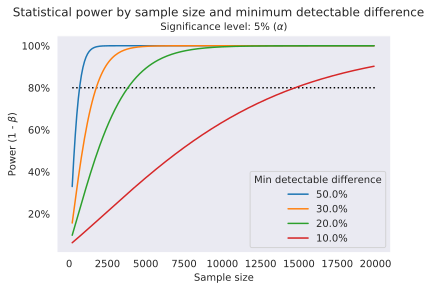

In [170]:
abtester.plot_power_vs_sample_size(min_sample_size=200, max_sample_size=20000, step_sample_size=100,
                                   min_diffs=[0.1, 0.2, 0.3, 0.5])

#### other tests.......

In [81]:
# finding the power of a t-test (non-independent????)
smp.ttest_power(effect_size=0.2, nobs=60, alpha=0.1, alternative='two-sided')   
# p = pwr.t.test(d=0.2, n=60, sig.level=0.10, type="one.sample", alternative="two.sided"); p$power    # 0.45 in R

# Another way of finding the power of a t-test:
# smp.tt_solve_power(nobs=60, effect_size=0.2, alpha=0.1, alternative='two-sided')  # same as R's pwr:

0.45558175996348543

In [75]:
# finding the power of a t-test (independent)
smp.tt_ind_solve_power(nobs1=120.2232, effect_size=0.3, 
                       ratio=1, alpha=0.05, alternative='larger')  # same as R's pwr:

0.7499999914013884

In [74]:
# Finding the min sample size needed
smp.tt_ind_solve_power(nobs1=None, effect_size=0.3, power=0.75, 
                       ratio=1, alpha=0.05, alternative='larger')  # same as R's pwr:
# p = pwr.t.test(d=0.3, power=0.75, sig.level=0.05, type="two.sample", alternative="greater"); p$n   # 120.22 in R

# Other way of calculating it in Python:
# smp.TTestIndPower().solve_power(nobs1=None, effect_size=0.3, power=0.75, 
#                                 ratio=1, alpha=0.05, alternative='larger')   # Same as R pwr

120.22320283709918

## Frequentist A/B testing

## Bayesian approach to A/B testing